In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import warnings
warnings.filterwarnings('ignore')


In [2]:
# All column names are secured
df = pd.read_csv('creditcard.csv')
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [3]:
neg, pos = np.bincount(df['Class'])
total = neg + pos
print('Total observations: {}\nFraud: {} ({:.2f}% of the Total)\n'.format(total, pos, 100 * pos / total))

Total observations: 284807
Fraud: 492 (0.17% of the Total)



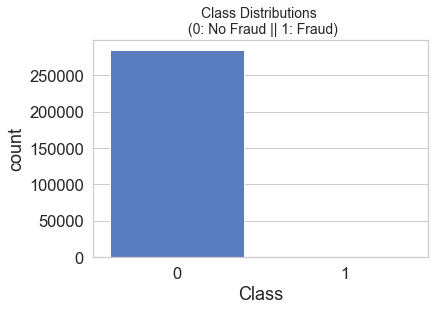

In [4]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

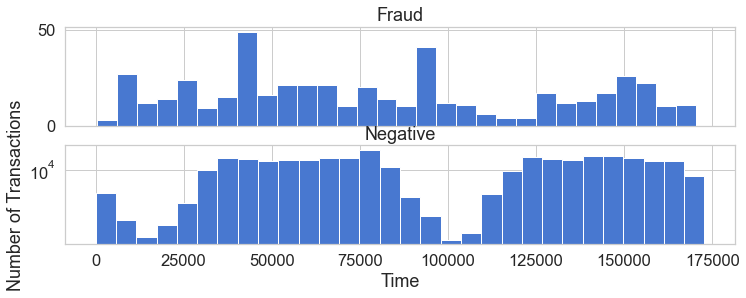

In [5]:
# Fraud is relatively uniformly distributed
# Time might be not big deal
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30

ax1.hist(df.Time[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Time[df.Class == 0], bins = bins)
ax2.set_title('Negative')

plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

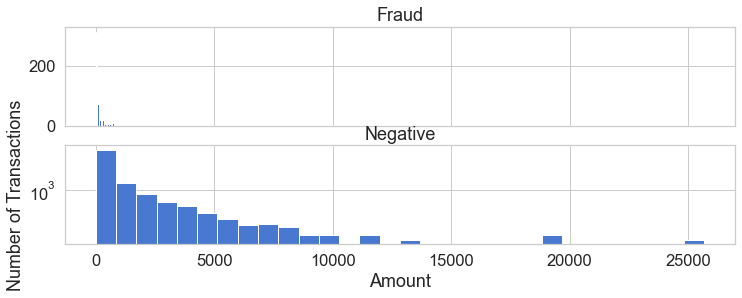

In [6]:
# Low Amount transactions are more likely to be considered as fraud transactions
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

bins = 30
ax1.hist(df.Amount[df.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(df.Amount[df.Class == 0], bins = bins)
ax2.set_title('Negative')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

In [7]:
df.isnull().values.any()

False

In [8]:
from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report, recall_score
import matplotlib.gridspec as gridspec

In [9]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(10000)
df1 = df.query('Class == 1')
df_under = pd.concat([df0, df1])

In [10]:
df_under.shape

(10492, 31)

In [11]:
X = df_under.iloc[:,:-1]
y = df_under['Class']

In [12]:
X = X.drop(['Time'], axis=1)

In [13]:
X['Amount'] = StandardScaler().fit_transform(X['Amount'].values.reshape(-1,1))

In [14]:
# 6 : 2 : 2
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test,
                                                   test_size = 0.5, random_state=0)

In [15]:
# 입력값 x를 받아서 다시 입력값 x를 결과로 뱉어내는 함수'가 바로 Autoencoder 신경망

In [16]:
# 우리가 특정한 데이터의 압축된 표상(representation)을 학습시키고 그 구조(structure)를 찾고 싶어한다는 점이 중요합니다. 
# 이것은 모델 안에 있는 은닉 유닛(hidden unit)의 수를 제한하는 방법을 통해 가능합니다. 
# 이런 종류의 autoencoder들은 미완성(undercomplete) 이라 불립니다.

In [28]:
input_dim = X_train.shape[1]
encoding_dim = 24

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [29]:
nb_epoch = 30
batch_size = 16
autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy','mae'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

2022-05-29 11:22:42.671039: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-29 11:22:42.671069: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-29 11:22:42.671537: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


Epoch 1/30
200/394 [==============>...............] - ETA: 0s - loss: 2.2551 - accuracy: 0.1166 - mae: 0.7503

2022-05-29 11:22:43.122884: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-29 11:22:43.122905: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-29 11:22:43.162533: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-29 11:22:43.163471: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-29 11:22:43.164909: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_05_29_11_22_43

2022-05-29 11:22:43.165823: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2022_05_29_11_22_43/Ming9ui-MacBookPro.local.trace.json.gz
2022-05-29 11:22:43.167287: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2022_05_29_11_22_43

2022-05-29 

394/394 [==============================] - 1s 1ms/step - loss: 2.2016 - accuracy: 0.1673 - mae: 0.7332 - val_loss: 2.0604 - val_accuracy: 0.3494 - val_mae: 0.7024
Epoch 2/30
394/394 [==============================] - 0s 1ms/step - loss: 2.0434 - accuracy: 0.4837 - mae: 0.6851 - val_loss: 1.9768 - val_accuracy: 0.5348 - val_mae: 0.6699
Epoch 3/30
394/394 [==============================] - 0s 1ms/step - loss: 1.9918 - accuracy: 0.5549 - mae: 0.6648 - val_loss: 1.9354 - val_accuracy: 0.5772 - val_mae: 0.6535
Epoch 4/30
394/394 [==============================] - 0s 1ms/step - loss: 1.9539 - accuracy: 0.5868 - mae: 0.6486 - val_loss: 1.9041 - val_accuracy: 0.6092 - val_mae: 0.6399
Epoch 5/30
394/394 [==============================] - 0s 960us/step - loss: 1.9261 - accuracy: 0.6095 - mae: 0.6377 - val_loss: 1.8811 - val_accuracy: 0.6311 - val_mae: 0.6314
Epoch 6/30
394/394 [==============================] - 0s 917us/step - loss: 1.9085 - accuracy: 0.6181 - mae: 0.6308 - val_loss: 1.8699 - va

In [30]:
autoencoder = load_model('model.h5')

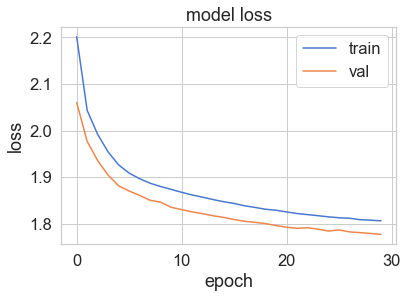

In [31]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right');

In [32]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,2099.000000,2099.000000
mean,1.736092,0.043354
std,11.826982,0.203701
min,0.055677,0.000000
25%,0.241823,0.000000
50%,0.388768,0.000000
75%,0.652443,0.000000
max,433.309240,1.000000


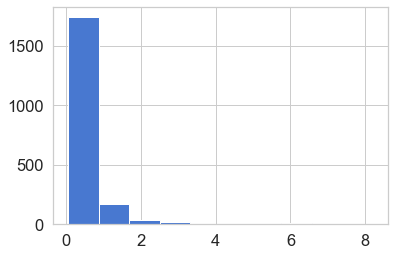

In [33]:
# normal datas
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

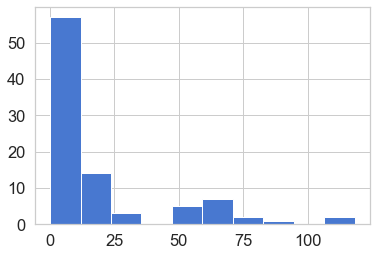

In [34]:
# anomalies
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [43]:
threshold = 1.0

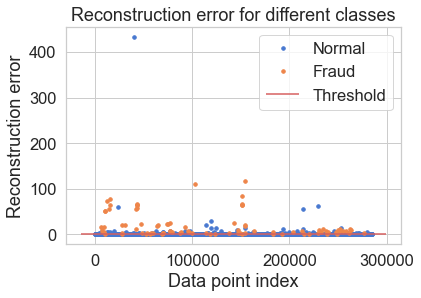

In [44]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

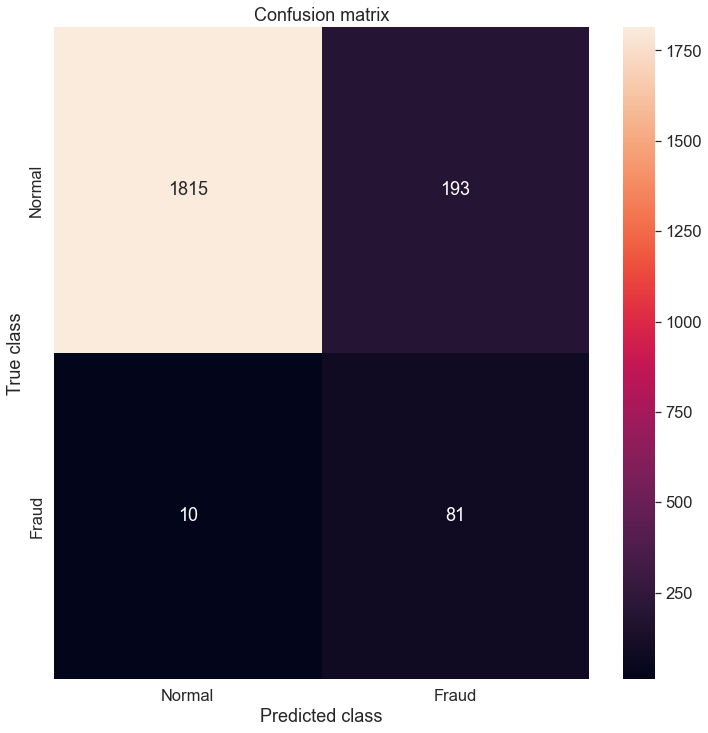

In [45]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [46]:
print(classification_report(error_df.true_class, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95      2008
           1       0.30      0.89      0.44        91

    accuracy                           0.90      2099
   macro avg       0.65      0.90      0.70      2099
weighted avg       0.96      0.90      0.93      2099

